# Pytorch Session 2: Linear regression, logistic regression, and optimization

## Data and goal for linear regression:

Let's create the data ```X: [N, P]``` and ```Y: [N, 1]```, and our goal is to estimate ```beta: [3,1]``` so that 

```Y_hat = X@beta```

best dedscribes ```Y```. We pretend that we only observe ```X``` and ```Y``` but we do not know real `beta`. 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N=10000
w_true = torch.Tensor([[1.0],[2.0],[3.0]])
X=torch.cat([torch.ones(N,1), torch.randn(N,2)], axis=1)
Y= X@w_true + 0.5*torch.randn(N,1)
print(X.shape, Y.shape, w_true.shape)

torch.Size([10000, 3]) torch.Size([10000, 1]) torch.Size([3, 1])


## 2.1 Optimization using vanilla pytorch

In [ ]:
w = torch.randn([3,1], requires_grad=True) # Anyway we need to provide the initial guess on w
lr = 0.1
history = []
epochs = 100

In [ ]:
for epoch in range(epochs):
  Y_hat = X@w
  w.grad=None
  loss = torch.mean((Y-Y_hat)**2)
  loss.backward()
  w.data = w.data - lr * w.grad
  history.append(loss.item())

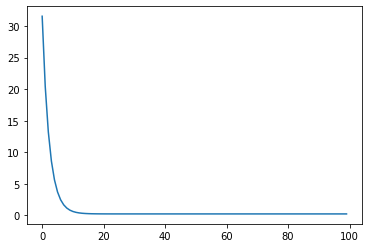

In [ ]:
plt.plot(history)

In [ ]:
w.data

tensor([[0.9985],
        [1.9954],
        [3.0013]])

## 2.2 Optimization using torch.nn (troch.nn.Linear)

First, we define the Linear layer where weight and bias parameters are accompanied. 

`y_hat = X w^T +b`

where `X: [N, P-1]` `w^T: [P-1, 1]` and `b: [1]`.

In [ ]:
model = torch.nn.Linear(in_features=2, out_features=1, bias=True) # You first need to define the model before use.
list(model.named_parameters())

[('weight', Parameter containing:
  tensor([[0.4854, 0.4939]], requires_grad=True)),
 ('bias', Parameter containing:
  tensor([-0.4578], requires_grad=True))]

In [ ]:
for name, param in model.named_parameters():
  print(name)

weight
bias


In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[0.4854, 0.4939]], requires_grad=True), Parameter containing:
 tensor([-0.4578], requires_grad=True)]

In [ ]:
model.weight

Parameter containing:
tensor([[0.4854, 0.4939]], requires_grad=True)

In [ ]:
model.bias

Parameter containing:
tensor([-0.4578], requires_grad=True)

In [ ]:
print(model.weight.T.shape, model.bias.shape) # Caution transpose is used!!!!

torch.Size([2, 1]) torch.Size([1])


In [ ]:
model.parameters

<bound method Module.parameters of Linear(in_features=2, out_features=1, bias=True)>

### Let's train the linear regression using torch.nn.Linear with given data `X` and `Y`.

In [ ]:
X[:, 1:].shape

torch.Size([10000, 2])

In [ ]:
X.shape

torch.Size([10000, 3])

In [ ]:
model = torch.nn.Linear(2,1, bias=True)


In [ ]:
model(X[:, 1:])

tensor([[ 0.2834],
        [-0.6874],
        [-1.1661],
        ...,
        [ 0.6584],
        [-0.3953],
        [ 0.9630]], grad_fn=<AddmmBackward0>)

In [ ]:
model = torch.nn.Linear(2,1, bias=True)

# Here we do not define w
history = []
lr=0.1
epochs=100

for epoch in range(epochs):
  Y_hat = model(X[:, 1:])
  model.zero_grad()
  loss = torch.mean((Y_hat-Y)**2)
  loss.backward()
  model.weight.data, model.bias.data = model.weight.data - lr * model.weight.grad, model.bias.data - lr * model.bias.grad
  history.append(loss.item())



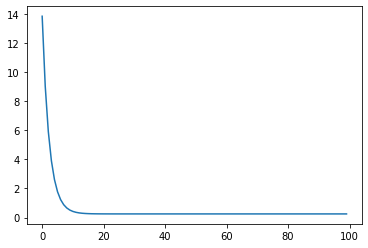

In [ ]:
plt.plot(history)

In [ ]:
print(model.bias.data, model.weight.data)

tensor([0.9985]) tensor([[1.9954, 3.0013]])


## 2.3 Optimization using torch.nn and torch.optim

In [ ]:
model = torch.nn.Linear(2, 1, bias = True) # You first need to define the layer before use.
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.1) # Define the optimizer


In [ ]:
history = []
lr=0.1
epochs=100

for epoch in range(epochs):
  Y_hat = model(X[:, 1:])
  optimizer.zero_grad() # It is okay to replace this with model.zero_grad()
  loss = torch.mean( (Y_hat-Y)**2 )
  loss.backward()
  optimizer.step()
  history.append(loss.item())

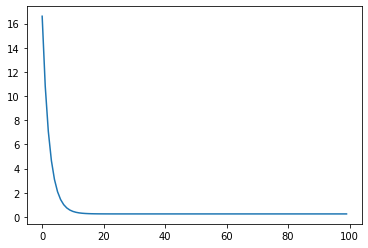

In [ ]:
plt.plot(history)

In [ ]:
list(model.named_parameters())

[('weight', Parameter containing:
  tensor([[1.9954, 3.0013]], requires_grad=True)),
 ('bias', Parameter containing:
  tensor([0.9985], requires_grad=True))]

## Example 2.2.1: 
Use optmizer to do the following instead of ```w.data = w.data - lr * w.grad.data```

In [ ]:
history=[]
w = torch.randn([2,1], requires_grad=True)
b = torch.randn([1], requires_grad=True)
lr=0.1
epochs = 20

for epoch in range(epochs):
  Y_hat = X[:, 1:]@w + b
  loss = torch.mean((Y-Y_hat)**2)
  loss.backward()
  #w.data = w.data - lr * w.grad.data
  #b.data = b.data - lr * b.grad.data
  history.append(loss.item())


## 2.4. Logistic regression

First, we prepare the data.

In [ ]:
import pandas as pd
candidates = {'gmat': [780,750,690,710,680,730,690,720,740,690,610,690,710,680,770,610,580,650,540,590,620,600,550,550,570,670,660,580,650,660,640,620,660,660,680,650,670,580,590,690],
              'gpa': [4,3.9,3.3,3.7,3.9,3.7,2.3,3.3,3.3,1.7,2.7,3.7,3.7,3.3,3.3,3,2.7,3.7,2.7,2.3,3.3,2,2.3,2.7,3,3.3,3.7,2.3,3.7,3.3,3,2.7,4,3.3,3.3,2.3,2.7,3.3,1.7,3.7],
              'work_experience': [3,4,3,5,4,6,1,4,5,1,3,5,6,4,3,1,4,6,2,3,2,1,4,1,2,6,4,2,6,5,1,2,4,6,5,1,2,1,4,5],
              'admitted': [1,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1]
              }

df = pd.DataFrame(candidates,columns= ['gmat', 'gpa','work_experience','admitted'])
df.head()

,gmat,gpa,work_experience,admitted
0,780,4.0,3,1
1,750,3.9,4,1
2,690,3.3,3,0
3,710,3.7,5,1
4,680,3.9,4,0


In [ ]:
pre_XX = df.iloc[:, :3].to_numpy()
YY = df.iloc[:, 3:].to_numpy()
print(XX.shape, YY.shape)

torch.Size([40, 3]) (40, 1)


* Caution: Data is severely unnormalized. Need normalization.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(pre_XX)

MinMaxScaler()

In [ ]:
XX=scaler.transform(pre_XX)

In [ ]:
XX=torch.tensor(XX, dtype=torch.float32)
YY=torch.tensor(YY, dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Now we train the model.

In [ ]:
model = torch.nn.Linear(3, 1, bias = True) # You first need to define the layer before use.
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.1) # Define the optimizer
# Now we define the MSE loss function for the logistic regression.
def my_loss(y_hat, y):
  return -torch.mean(y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat))

In [ ]:
history = []
lr=0.1
epochs=10000
sigmoid = torch.nn.Sigmoid()

for epoch in range(epochs):
  Y_hat = sigmoid(model(XX))
  optimizer.zero_grad() # It is okay to replace this with model.zero_grad()
  loss = my_loss(Y_hat, YY)
  loss.backward()
  optimizer.step()
  history.append(loss.item())

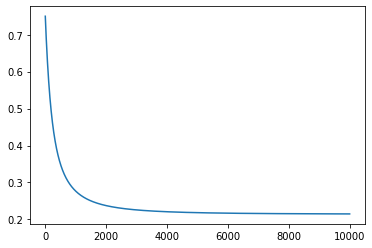

In [ ]:
plt.plot(history)

In [ ]:
Y_hat = (sigmoid(model(XX))>0.5).type(torch.float32)
torch.mean((YY==Y_hat).type(torch.float32))

tensor(0.9250)

## 2.5. Batch learning and TensorDataset and DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

mydata = TensorDataset(X, Y)
dataloader = DataLoader(mydata, batch_size= 32, shuffle=True)

In [ ]:
model  = torch.nn.Linear(3, 1, bias=False)
lr=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
history=[]
epochs = 30
def loss_ftn(y_hat, y):
  return torch.mean((y_hat-y)**2)



In [ ]:
for epoch in range(epochs):
  running_loss = 0
  for xx, yy in dataloader:
    optimizer.zero_grad()
    y_pred = model(xx)
    loss = loss_ftn(y_pred, yy)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  history.append(running_loss)
    

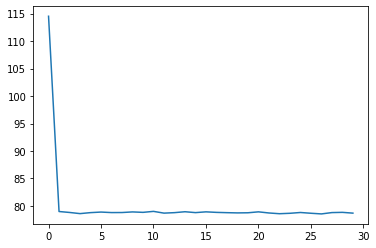

In [ ]:
plt.plot(history)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[1.0022, 2.0172, 3.0141]], requires_grad=True)]

## Example 2.5.1. Logistic regression.

Using the admitted data, `XX` and `YY`, in Section 2.4, do the batch learning using `DataLoader` with batch size 32.

## 2.6 Using GPU

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [ ]:
model  = torch.nn.Linear(3, 1, bias=False).to(DEVICE)
lr=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
history=[]
epochs = 30
def loss_ftn(y_hat, y):
  return torch.mean((y_hat-y)**2)

In [ ]:
for epoch in range(epochs):
  running_loss = 0
  for xx, yy in dataloader:
    xx = xx.to(DEVICE)
    yy = yy.to(DEVICE)
    optimizer.zero_grad()
    y_pred = model(xx)
    loss = loss_ftn(y_pred, yy)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  history.append(running_loss)
    

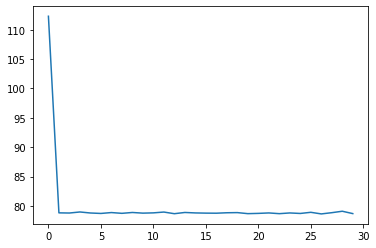

In [ ]:
plt.plot(history)

In [ ]:
#Y_hat = model(X) #error because parameters in model is in cuda
model.to("cpu")
Y_hat = model(X)

## 2.7. Use train and evaluate function


- In the above procedure train procedure, almost the same grammar is repeatedly used. Hence, it is good to have train function. Similary, we can use evaluate function to check the learning process.

In [1]:
# The following function is for batch learning in one epoch
def train(model, train_loader, optimizer, my_loss, check_interval):
  # model should be attached to the device to be used.
  # check_interval: how often you want to check the loss
  model.train() # Declair that model is in training process such as Dropout layer BatchNorm layer.
  running_loss = 0
  for batch_idx, (xx, yy) in enumerate(train_loader):
    xx = xx.to(DEVICE)
    yy = yy.to(DEVICE)
    optimizer.zero_grad()
    y_hat = model(xx)
    loss = my_loss(y_hat, yy)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*len(xx)
    if batch_idx % check_interval ==0:
      print("Train epoch: {} [{}/{}]".format(epoch, batch_idx*len(xx), len(train_loader.dataset)) )
  train_loss = running_loss/len(train_loader.dataset)
  print("Train epoch = {}, train loss = {}".format(epoch, train_loss))
  return train_loss

In [ ]:
mydata = TensorDataset(X, Y)
dataloader = DataLoader(mydata, batch_size= 32, shuffle=True)

In [ ]:
DEVICE = torch.device("cuda")
model = torch.nn.Linear(X.shape[1], 10).to(DEVICE)
my_loss  = torch.nn.MSELoss() # look: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#def train(model, train_loader, optimizer, my_loss, check_interval):
epochs=10
history = []
for epoch in range(epochs):
  current_loss = train(model, dataloader, optimizer, my_loss, 200)
  history.append(current_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train epoch: 0 [0/10000], Train loss = 19.333887100219727
Train epoch: 0 [6400/10000], Train loss = 2199.2619416713715
Train epoch: 1 [0/10000], Train loss = 5.671508312225342


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train epoch: 1 [6400/10000], Train loss = 646.7053076028824
Train epoch: 2 [0/10000], Train loss = 2.1252362728118896
Train epoch: 2 [6400/10000], Train loss = 220.5539548099041
Train epoch: 3 [0/10000], Train loss = 0.9129893183708191
Train epoch: 3 [6400/10000], Train loss = 97.99750801920891
Train epoch: 4 [0/10000], Train loss = 0.4081669747829437
Train epoch: 4 [6400/10000], Train loss = 64.20281472802162
Train epoch: 5 [0/10000], Train loss = 0.3348357081413269
Train epoch: 5 [6400/10000], Train loss = 54.80656182765961
Train epoch: 6 [0/10000], Train loss = 0.2034042328596115
Train epoch: 6 [6400/10000], Train loss = 51.25862255692482
Train epoch: 7 [0/10000], Train loss = 0.19315305352210999
Train epoch: 7 [6400/10000], Train loss = 50.000013276934624
Train epoch: 8 [0/10000], Train loss = 0.2900976240634918
Train epoch: 8 [6400/10000], Train loss = 50.00887852907181
Train epoch: 9 [0/10000], Train loss = 0.31533557176589966
Train epoch: 9 [6400/10000], Train loss = 51.36202167

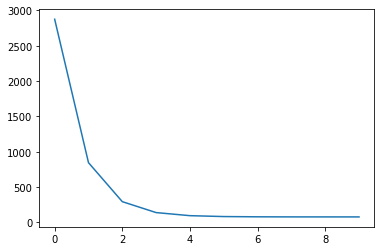

In [ ]:
plt.plot(history)

## Example 2.7.1. 

Using the admitted data, `XX` and `YY`, in Section 2.4, use the function `train` to do the batch learning using `DataLoader` with batch size 32.